# Imports

In [1]:
import os
os.chdir("/Users/evanrootness/Project1/EtsyDSProject")
pwd = os.getcwd()
print(pwd)

/Users/evanrootness/Project1/EtsyDSProject


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import math
import scipy.optimize as opt
import seaborn as sns
from sklearn.model_selection import train_test_split
import sys  

In [3]:
import_data = pd.read_csv(pwd + '/data/ArtAllPages.csv')
# import_data = pd.read_csv(pwd + '/data/art_map.csv')
raw_data = import_data.copy()

# Data Cleaning

In [4]:
data = raw_data.drop(['web-scraper-order', 'web-scraper-start-url', 'product_link-href', 'Pagination', 'product_link'], axis = 1)

In [5]:
print(data.shape)
data

(1111, 3)


,name,min_price,size_options
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",Price:\n $6.00,[]
1,"San Francisco Print, Golden Gate Bridge Wall A...",Price:\n $18.00+,"[{""size_options"":""Select an option\n ..."
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",Price:\n $82.00+,"[{""size_options"":""Select a size\n ..."
3,Whale nursery art. Whale Rider print,Price:\n $20.00+,"[{""size_options"":""Select a size\n ..."
4,Valentine's Day Copper Rose / Seventh Annivers...,Price:\n $160.00+,"[{""size_options"":""Select an option\n ..."
...,...,...,...
1106,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",Price:\n $4.80,[]
1107,"Tropical Little Thing Mini Crab, Driftwood Wal...",Price:\n $150.00,[]
1108,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",Price:\n $2.00,[]
1109,Pheasant Art Print Giclee Limited Edition,Price:\n $39.89,[]


In [6]:
data['size_options'][1]

'[{"size_options":"Select an option\\n                \\n                \\n                        5x7 ($18.00)\\n                \\n                \\n                        8x10 ($36.00)\\n                \\n                \\n                        11x14 ($56.00)\\n                \\n                \\n                        12x16 ($71.00)\\n                \\n                \\n                        16x20 ($102.00)\\n                \\n                \\n                        20x24 ($128.00)\\n                \\n                \\n                        20x30 ($138.00)\\n                \\n                \\n                        24x30 ($153.00)\\n                \\n                \\n                        24x36 ($163.00)"}]'

In [7]:
data.describe()

,name,min_price,size_options
count,1111,1111,1111
unique,1041,508,412
top,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",Price:\n $18.00+,[]
freq,5,32,547


In [8]:
# data.rename(columns={'shop_star_rating': 'stars'}, inplace=True)

In [9]:
# data.fillna(value='0', inplace=True)

In [10]:
data = data.astype(dtype='string')

In [11]:
data.dtypes

name            string[python]
min_price       string[python]
size_options    string[python]
dtype: object

In [12]:
# data_num = pd.DataFrame(data={'price': data['price'], 'reviews_product': data['reviews_product'], 
#                               'reviews_shop': data['reviews_shop'], 'stars': data['stars']})
# data_num

In [13]:
import re
# name = "price: $48.00"
# test = re.search('[^\$]*$', name)
# print(test)
# print(test.group(0))

In [14]:
price = []
# reviews_product = []
# reviews_shop = []
# stars = []

for i in range(len(data['min_price'])):
    price.append(re.search('[^+]*', data['min_price'][i]).group(0))
    price[i] = re.search('[^\$]*$', price[i]).group(0).replace(',', '')
    
    # reviews_product.append(int(data_num['reviews_product'][i].replace(',', '')))
    # reviews_shop.append(int(data_num['reviews_shop'][i].replace(',', '')))
    # stars.append(re.search('[^\s]*', data_num['stars'].astype(dtype='string')[i]).group(0))

# datnum = []
# all_rows = [price, reviews_product, reviews_shop, stars]
# for row in all_rows:
#     datnum.append(row)
# data_num_int = pd.DataFrame(data={'price': datnum[0], 'reviews_product': datnum[1], 
#                                   'reviews_shop': datnum[2], 'stars': datnum[3]})

data['min_price'] = price
# data['reviews_product'] = reviews_product
# data['reviews_shop'] = reviews_shop
# data['stars'] = stars

In [15]:
data = data.rename(columns={'min_price': 'price'})

In [16]:
data['price'] = data['price'].astype(float)

In [17]:
# data_num_int

## Convert Names to Categorical Data

In [18]:
def addCategoricalLists(init_data, list_of_categories):
    for category in list_of_categories:
        temp_category_list = []
        for i in range(len(init_data)):
            if (category in init_data['name'][i]):
                temp_category_list.append(1)
            else:
                temp_category_list.append(0)
        data[str(category)] = temp_category_list    

In [19]:
addCategoricalLists(data, ['Watercolor', 'Portrait', 'Pet', 'Print', 'Family', 'Paint', 'Painting', 'Nature', 'Custom'])

In [20]:
data

,name,price,size_options,Watercolor,Portrait,Pet,Print,Family,Paint,Painting,Nature,Custom
0,"Pastel Art, Mint Green Wall Art, Mint Green Ar...",6.00,[],1,0,0,1,0,0,0,0,0
1,"San Francisco Print, Golden Gate Bridge Wall A...",18.00,"[{""size_options"":""Select an option\n ...",0,0,0,1,0,0,0,0,0
2,"Set 4 Coral Prints Mist Blue/Green, Nautical p...",82.00,"[{""size_options"":""Select a size\n ...",0,0,0,1,0,0,0,0,0
3,Whale nursery art. Whale Rider print,20.00,"[{""size_options"":""Select a size\n ...",0,0,0,0,0,0,0,0,0
4,Valentine's Day Copper Rose / Seventh Annivers...,160.00,"[{""size_options"":""Select an option\n ...",0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1106,"Yellow Leopard 20oz Tumbler Sublimation Wrap,G...",4.80,[],0,0,0,0,0,0,0,0,0
1107,"Tropical Little Thing Mini Crab, Driftwood Wal...",150.00,[],0,0,0,0,0,0,0,0,0
1108,"Fall Pumpkin Mug Sublimation, Watercolor Flora...",2.00,[],1,0,0,0,0,0,0,0,0
1109,Pheasant Art Print Giclee Limited Edition,39.89,[],0,0,0,1,0,0,0,0,0


# Data Exploration

In [21]:
# sns.heatmap(data_num_int.corr())

(array([1.037e+03, 2.300e+01, 1.100e+01, 1.100e+01, 5.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 2.000e+00, 2.000e+01]),
 array([1.800000e-01, 1.801620e+02, 3.601440e+02, 5.401260e+02,
        7.201080e+02, 9.000900e+02, 1.080072e+03, 1.260054e+03,
        1.440036e+03, 1.620018e+03, 1.800000e+03]),
 <BarContainer object of 10 artists>)

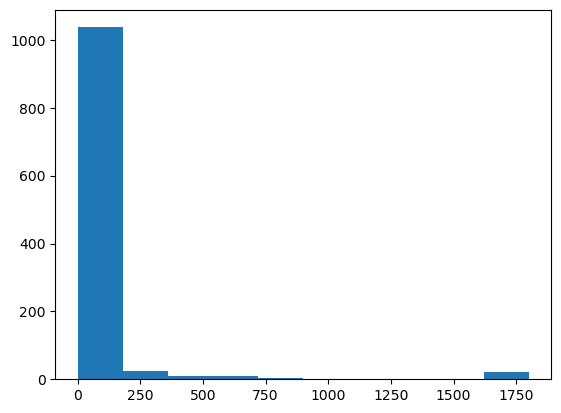

In [22]:
plt.hist(data['price'])

In [36]:
data_cheap = data.where(data['price'] < 200).dropna()
data_expensive = data.where(data['price'] > 200).dropna()

(array([526., 309.,  99.,  36.,  24.,  18.,   7.,  11.,   4.,   7.]),
 array([1.80000e-01, 2.01170e+01, 4.00540e+01, 5.99910e+01, 7.99280e+01,
        9.98650e+01, 1.19802e+02, 1.39739e+02, 1.59676e+02, 1.79613e+02,
        1.99550e+02]),
 <BarContainer object of 10 artists>)

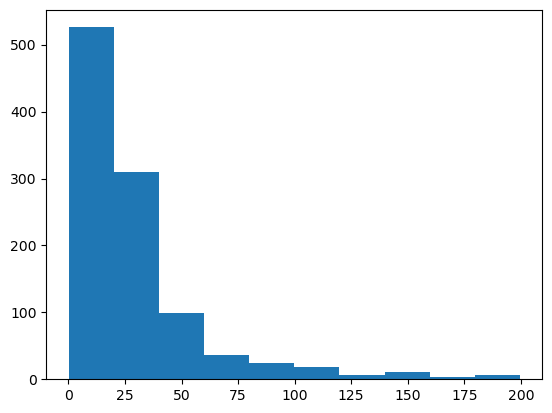

In [39]:
plt.hist(data_cheap['price'])

(array([18., 11.,  8.,  8.,  1.,  0.,  1.,  0.,  2., 20.]),
 array([ 210.,  369.,  528.,  687.,  846., 1005., 1164., 1323., 1482.,
        1641., 1800.]),
 <BarContainer object of 10 artists>)

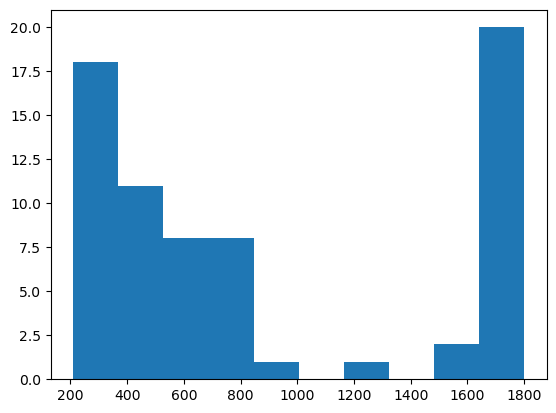

In [40]:
plt.hist(data_expensive['price'])

Text(0, 0.5, 'Average Price')

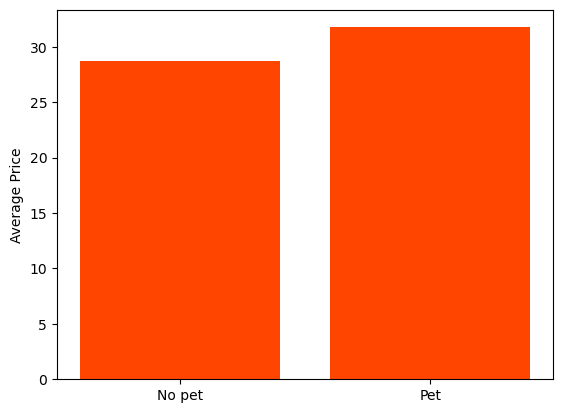

In [32]:
avg_price_pet = np.mean(data_cheap.where(data_cheap['Pet'] == 1).dropna()['price'].astype(float))
avg_price_no_pet = np.mean(data_cheap.where(data_cheap['Pet'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No pet', 'Pet'], height=[avg_price_no_pet, avg_price_pet], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

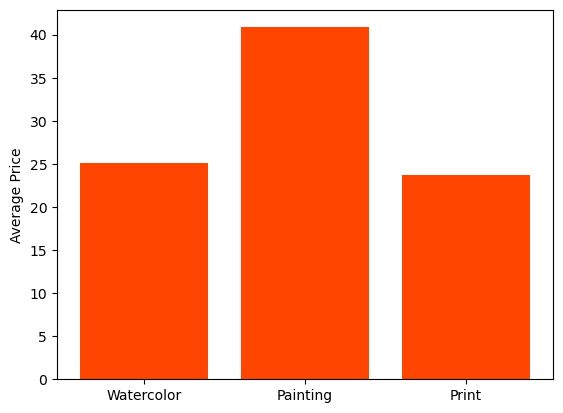

In [33]:
avg_price_watercolor = np.mean(data_cheap.where(data_cheap['Watercolor'] == 1).dropna()['price'].astype(float))
avg_price_painting = np.mean(data_cheap.where((data_cheap['Paint'] == 1) | (data_cheap['Painting'] == 1)).dropna()['price'].astype(float))
avg_price_print = np.mean(data_cheap.where(data_cheap['Print'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Watercolor', 'Painting', 'Print'], height=[avg_price_watercolor, avg_price_painting, avg_price_print], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

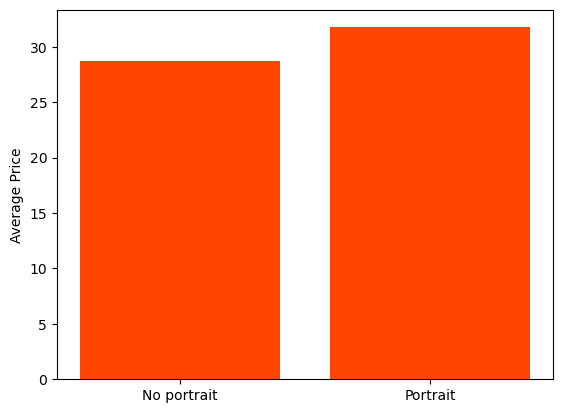

In [34]:
avg_price_portrait = np.mean(data_cheap.where(data_cheap['Portrait'] == 1).dropna()['price'].astype(float))
avg_price_no_portrait = np.mean(data_cheap.where(data_cheap['Portrait'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No portrait', 'Portrait'], height=[avg_price_no_pet, avg_price_pet], color = 'orangered')
plt.ylabel('Average Price')

Text(0, 0.5, 'Average Price')

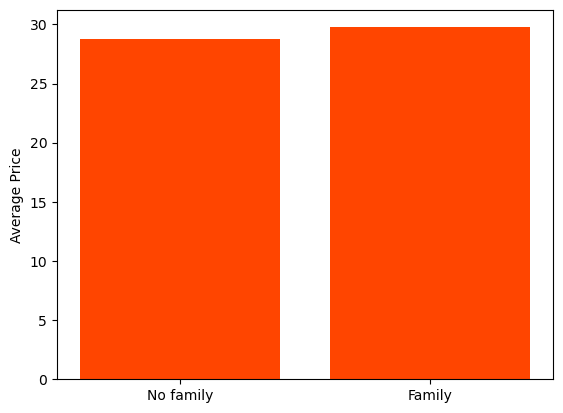

In [35]:
avg_price_family = np.mean(data_cheap.where(data_cheap['Family'] == 1).dropna()['price'].astype(float))
avg_price_no_family = np.mean(data_cheap.where(data_cheap['Family'] == 0).dropna()['price'].astype(float))
plt.bar(x=['No family', 'Family'], height=[avg_price_no_family, avg_price_family], color = 'orangered')
plt.ylabel('Average Price')

Expensive listings exploration

Text(0, 0.5, 'Average Price')

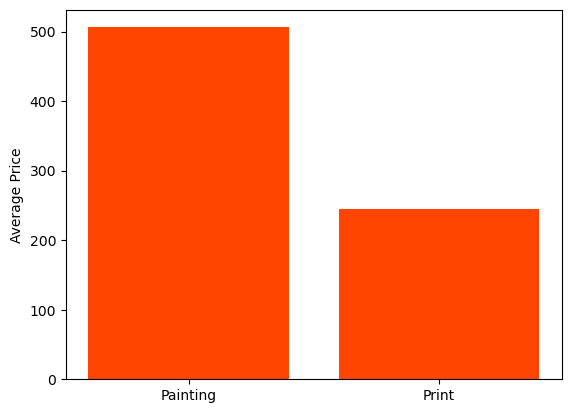

In [42]:
avg_price_watercolor = np.mean(data_expensive.where(data_expensive['Watercolor'] == 1).dropna()['price'].astype(float))
avg_price_painting = np.mean(data_expensive.where((data_expensive['Paint'] == 1) | (data_expensive['Painting'] == 1)).dropna()['price'].astype(float))
avg_price_print = np.mean(data_expensive.where(data_expensive['Print'] == 1).dropna()['price'].astype(float))
plt.bar(x=['Watercolor', 'Painting', 'Print'], height=[avg_price_watercolor, avg_price_painting, avg_price_print], color = 'orangered')
plt.ylabel('Average Price')